## Import Packages

In [1]:
import os
import plotly
import matplotlib
import pandas as pd
import fbprophet as ph

%matplotlib inline
import matplotlib.pyplot as plt
from fbprophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot
from pandas.plotting import autocorrelation_plot


from math import floor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm.notebook import tqdm

matplotlib.rcParams['figure.figsize'] = (12, 6)
axis_formatter = matplotlib.dates.DateFormatter('%Y-%m-%d %Hh') 


## Import Dataset
### Source
Hourly energy demand generation and weather  
https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather
### Content

This dataset contains 4 years of electrical consumption, generation, pricing, and weather data for Spain. Consumption and generation data was retrieved from ENTSOE a public portal for Transmission Service Operator (TSO) data. Settlement prices were obtained from the Spanish TSO Red Electric España. Weather data was purchased as part of a personal project from the Open Weather API for the 5 largest cities in Spain and made public here.  
  
  
### Inspirational Problems to Solve
- What weather measurements, and cities influence most the electrical demand, prices, generation capacity?
- Forecast 24 hours in advance?
- Predict electrical price by time of day?
- Forecast intraday price or electrical demand hour-by-hour.

In [2]:
## simple dataset
shampoo_df = pd.read_csv('dataset/shampoo_sale/shampoo.csv')
print(shampoo_df.shape)

## richer and more complex datasets
hourly_energy_df = pd.read_csv('dataset/hourly_energy_demand_generation_and_weather/energy_dataset.csv')
hourly_weather_df = pd.read_csv('dataset/hourly_energy_demand_generation_and_weather/weather_features.csv')
print(hourly_energy_df.shape)
print(hourly_weather_df.shape)

(36, 2)
(35064, 29)
(178396, 17)


In [83]:
hourly_energy_df.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')

In [84]:
hourly_energy_df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [85]:
hourly_weather_df.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


## Data Prep
Prophet requires time series data to have a minimum of two columns: `ds` which is the time stamp and `y` which is the values

In [3]:
shampoo_df['Month'] = pd.to_datetime(shampoo_df['Month'], format='%d/%m/%Y', utc=True).dt.date

In [86]:
hourly_energy_df['time'] = pd.to_datetime(hourly_energy_df['time'], utc=True)
# Remove timezone
hourly_energy_df['time'] = hourly_energy_df['time'].dt.tz_localize(None)
hourly_energy_df.sort_values('time', inplace=True)

In [87]:
len(hourly_energy_df)

35064

In [88]:
hist_size = 3/5
hourly_energy_hist = hourly_energy_df.head(floor(hist_size * len(hourly_energy_df)))[['time', 'price day ahead']]
hourly_energy_hist.columns = ['ds', 'y']
hourly_energy_hist.shape

(21038, 2)

### Optional: convert hourly data to daily average

In [95]:
daily_energy_df = hourly_energy_df.groupby([hourly_energy_df['time'].dt.date]).mean().reset_index()
daily_energy_df.head(3)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2014-12-31,447.000000,329.000000,0.0,4844.000000,4821.000000,162.000000,0.0,0.0,0.0,...,196.000000,0.0,6378.000000,17.000000,NaN,6436.000000,26118.000000,25385.000000,50.100000,65.410000
1,2015-01-01,425.208333,243.708333,0.0,4187.791667,4099.458333,161.500000,0.0,0.0,0.0,...,201.041667,0.0,3994.000000,1049.500000,NaN,3942.416667,24753.250000,23966.958333,45.031667,62.090833
2,2015-01-02,389.875000,0.000000,0.0,3566.166667,1258.125000,200.833333,0.0,0.0,0.0,...,186.583333,0.0,11060.041667,1187.208333,NaN,11117.041667,27519.416667,27188.541667,17.598333,69.443750


In [96]:
hist_size = 3/5
daily_energy_hist = daily_energy_df.head(floor(hist_size * len(daily_energy_df)))[['time', 'price day ahead']]
daily_energy_hist.columns = ['ds', 'y']
daily_energy_hist.shape

(877, 2)

## Building a ARIMA model

**ARIMA = AR + I + MA**  
  
  
**AR**: *Autoregression*. A model that uses the dependent relationship between an observation and some number of lagged observations.  
<br>
<center>$y_t = c + \phi_1y_{t-1} + \phi_2y_{t-2} + ... + \phi_1y_{t-p} + \epsilon_t$ </center>
  
**I**: *Integrated*. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.  
  
**MA**: *Moving Average*. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.  
<br>
<center>$y_t = c + \epsilon_t + \theta_1\epsilon_{t-1} + \theta_2\epsilon_{t-2} + ... + \theta_1\epsilon_{t-q}$ </center>
<br>

A MA model with order 1 (i.e. $q=1$)  
<br>
<center>$y_t = c + \epsilon_t + \theta_1\epsilon_{t-1}$
<br>

The parameters of the ARIMA model are defined as follows:  
  
**p** : The number of lag observations included in the model, also called the lag order.  

**d**: The number of times that the raw observations are differenced, also called the degree of differencing.  

**q**: The size of the moving average window, also called the order of moving average.  


In [4]:
shampoo_df.head()

,Month,Sales
0,2018-01-01,266.0
1,2018-02-01,145.9
2,2018-03-01,183.1
3,2018-04-01,119.3
4,2018-05-01,180.3


### Determining I

#### Explain "stationary"
if $y_t$ is a stationary time series, then for all $s$, the distribution of $y_t,...,y_{t+s}$ does not depend on $t$.  

#### Explain "differencing"
The difference of a Series element compared with another element in the Series

In [19]:
tmp_ls = [2,3,5,4,2,1,3,6,9]
pd.Series(tmp_ls)

0    2
1    3
2    5
3    4
4    2
5    1
6    3
7    6
8    9
dtype: int64

In [24]:
pd.concat([pd.Series(tmp_ls), pd.Series(tmp_ls).diff(periods=1)], axis=1)

,0,1
0,2,NaN
1,3,1.0
2,5,2.0
3,4,-1.0
4,2,-2.0
5,1,-1.0
6,3,2.0
7,6,3.0
8,9,3.0


In [25]:
pd.concat([pd.Series(tmp_ls), pd.Series(tmp_ls).diff(periods=3)], axis=1)

,0,1
0,2,NaN
1,3,NaN
2,5,NaN
3,4,2.0
4,2,-1.0
5,1,-4.0
6,3,-1.0
7,6,4.0
8,9,8.0


#### Check stationarity 

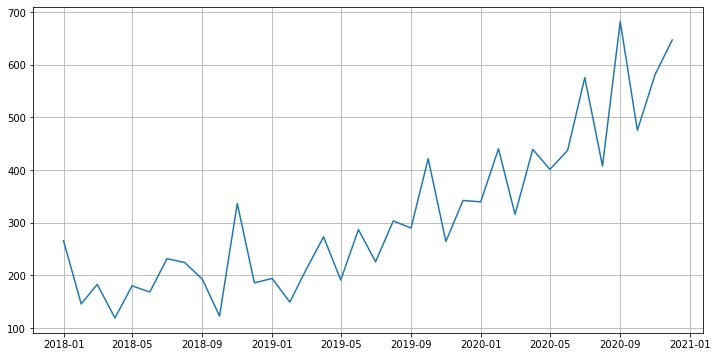

In [5]:
plt.plot(shampoo_df.Month,shampoo_df.Sales)
plt.grid(True)
plt.show()

This suggests that the time series is __not stationary__ and will require differencing to make it stationary, at least a difference order of 1.

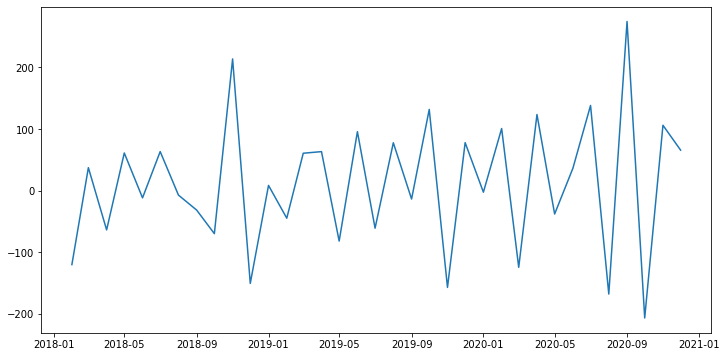

In [6]:
plt.plot(shampoo_df.Month, shampoo_df.Sales.diff(periods=1))

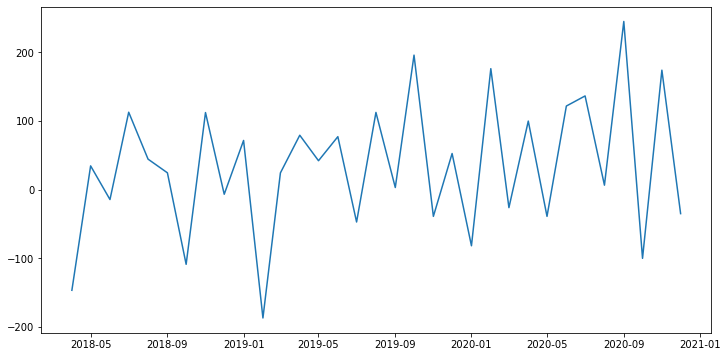

In [26]:
plt.plot(shampoo_df.Month, shampoo_df.Sales.diff(periods=3))

### Determining p with ACF
ACF is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values. In simple terms, it describes how well the present value of the series is related with its past values. A time series can have components like trend, seasonality, cyclic and residual. ACF considers all these components while finding correlations hence it’s a ‘complete auto-correlation plot’.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

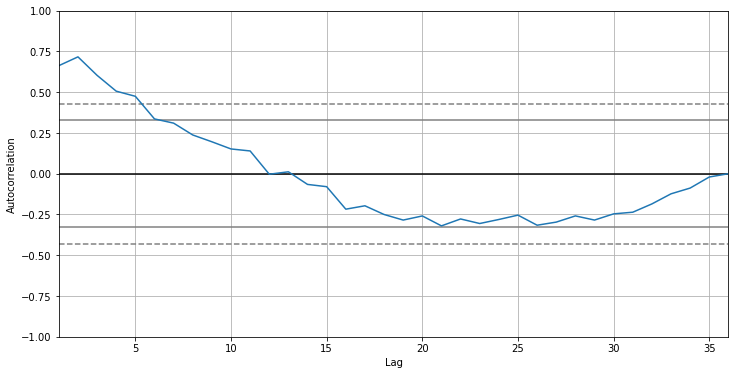

In [199]:
## Use autocorrelation_plot from pandas
autocorrelation_plot(shampoo_df.Sales)

Running the example, we can see that there is a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags.  
A good starting point for the AR parameter of the model may be 5

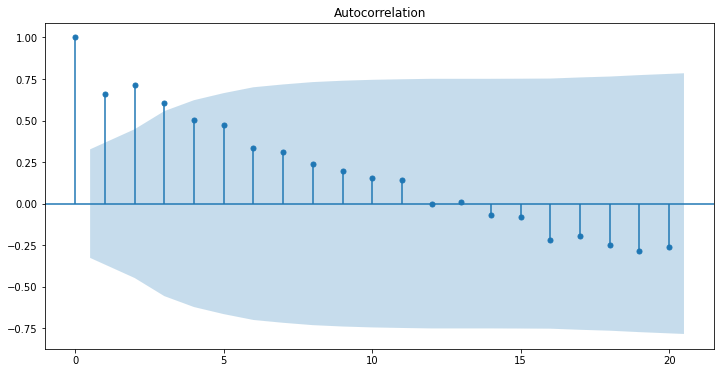

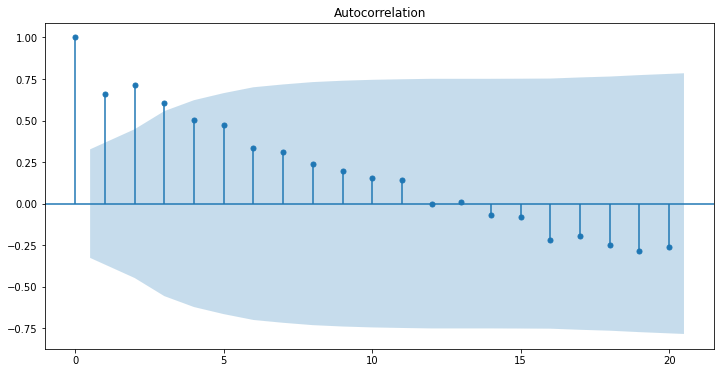

In [204]:
## Alternative use plot_acf from statsmodel
plot_acf(shampoo_df.Sales, lags=20)

### Determining q with PACF
PACF is a partial auto-correlation function. Basically instead of finding correlations of present with lags like ACF, it finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value hence ‘partial’ and not ‘complete’ as we remove already found variations before we find the next correlation. So if there is any hidden information in the residual which can be modeled by the next lag, we might get a good correlation and we will keep that next lag as a feature while modeling. Remember while modeling we don’t want to keep too many features which are correlated as that can create multicollinearity issues. Hence we need to retain only the relevant features.

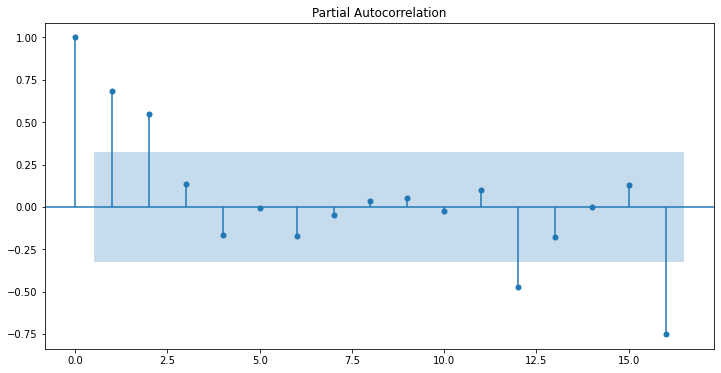

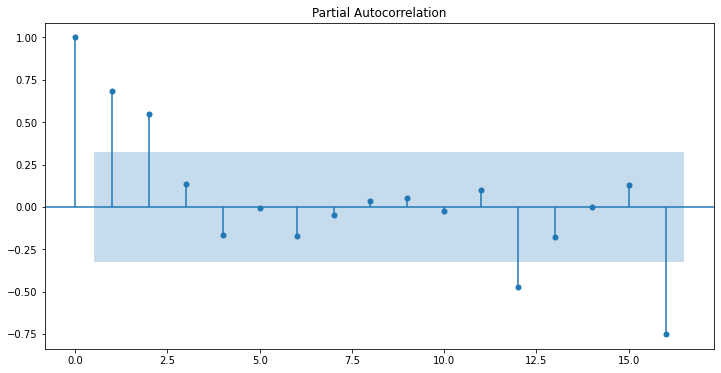

In [206]:
plot_pacf(shampoo_df.Sales)

In [215]:
model = ARIMA(shampoo_df.Sales, order=(5,2,2))
model_fit = model.fit()

In [217]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(5, 2, 2)   Log Likelihood                -191.901
Date:                Sun, 14 Feb 2021   AIC                            399.801
Time:                        16:08:37   BIC                            412.012
Sample:                             0   HQIC                           403.966
                                 - 36                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2741      3.066     -0.416      0.678      -7.283       4.735
ar.L2         -0.9934      3.912     -0.254      0.800      -8.661       6.674
ar.L3         -0.8128      2.923     -0.278      0.781      -6.542       4.917
ar.L4         -0.5075      2.312     -0.220      0.826      -5.038       4.023
ar.L5         -0.0803      1.328     -0.060      0.952      -2.684       2.523
ma.L1         -0.8519      3.156     -0.270      0.787      -7.037       5.333
ma.L2          0.0832      2.548      0.033      0.974      -4.910       5.077
sigma2      3996.2471   1308.563      3.054      0.002    1431.512    6560.983
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 0.42
Prob(Q):                              0.72   Prob(JB):                         0.81
Heteroskedasticity (H):               0.94   Skew:                            -0.00
Prob(H) (two-sided):                  0.92   Kurtosis:                         2.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Text(0.5, 1.0, 'line plot of residuals')

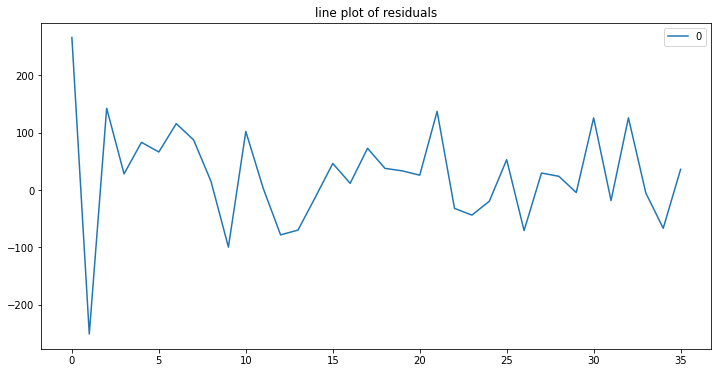

In [219]:
residuals = pd.DataFrame(model_fit.resid)

## line plot of residuals
residuals.plot()
plt.title('Line plot of residuals')

Text(0.5, 1.0, 'Density plot of residuals')

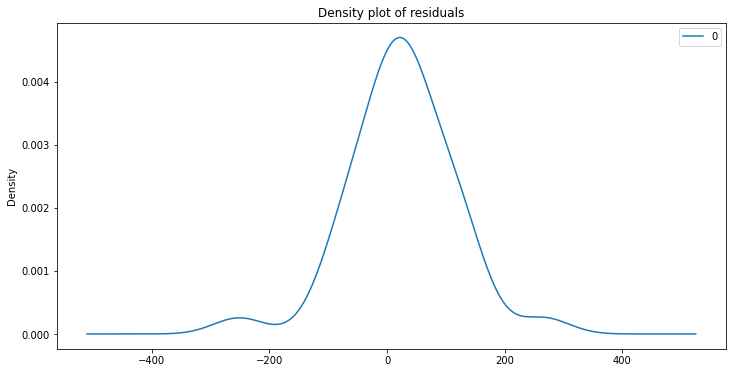

In [220]:
## density plot of residuals
residuals.plot(kind='kde')
plt.title('Density plot of residuals')

In [222]:
residuals.describe()

,0
count,36.000000
mean,24.806048
std,88.931498
min,-251.238807
25%,-18.718286
50%,26.920285
75%,75.248607
max,266.000000


In [ ]:
# daily_energy_hist.plot()
# plt.gcf().axes[0].xaxis.set_major_formatter(axis_formatter)

## Predict with Prophet

In [97]:
prophet = ph.Prophet()

In [98]:
prophet.fit(df=daily_energy_hist)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [99]:
## Add in 365 days in future, unit is day
# energy_future = prophet.make_future_dataframe(periods=365, freq='D')

## OR add in 1 year in future, unit is month 
energy_future = prophet.make_future_dataframe(periods=12 * 1, freq='M')

## OR add in 2 years in future, unit is year 
# energy_future = prophet.make_future_dataframe(periods=2, freq='Y')

In [100]:
energy_future.tail()

,ds
884,2017-12-31
885,2018-01-31
886,2018-02-28
887,2018-03-31
888,2018-04-30


In [101]:
forecast = prophet.predict(energy_future)

In [102]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
884,2017-12-31,70.910883,56.580816,83.969639
885,2018-01-31,85.131458,71.331725,99.362361
886,2018-02-28,75.427331,61.201057,89.622206
887,2018-03-31,71.630240,55.576768,85.772333
888,2018-04-30,78.227038,63.562049,93.336329


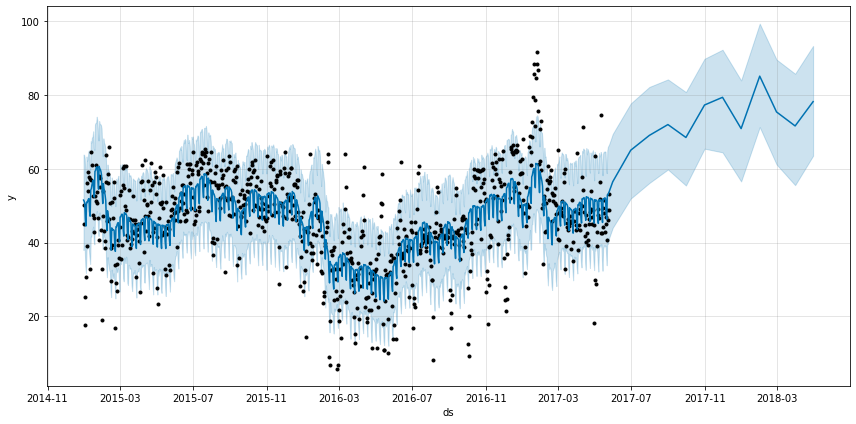

In [103]:
fig1 = prophet.plot(forecast, figsize=(12,6))

Prophet has included the original data as the black dots and the blue line is the forecast model. The light blue area is the confidence interval. Using the `add_changepoints_to_plot` function added the red lines; the vertical dashed lines are changepoints Prophet identified where the trend changed, and the solid red line is the trend with all seasonality removed. 

In [104]:
a = add_changepoints_to_plot(fig1.gca(), prophet, forecast)

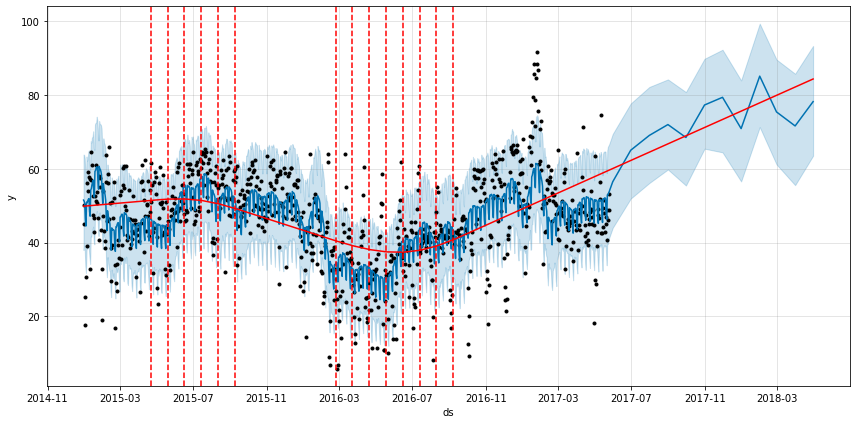

In [105]:
fig1

### Trend, yearly seasonality, and weekly seasonality of the time series

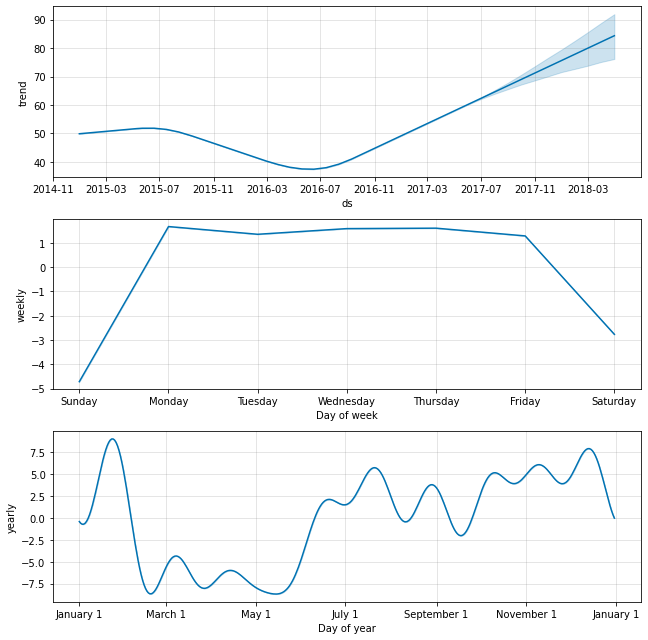

In [106]:
fig2 = prophet.plot_components(forecast)

In [ ]:
# plot_plotly(prophet, forecast)